# Ejercicio K-Means

In [122]:
import os
os.environ["OMP_NUM_THREADS"] = "1"  # Elimina el Warning al crear el modelo K-Means

In [124]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score

1. Importar archivo "Mall_Customers.csv"\
   El spending Score hace referencia a que tanto compra un cliente
   https://www.kaggle.com/datasets/vjchoudhary7/customer-segmentation-tutorial-in-python/data

In [127]:
data = pd.read_csv("Mall_Customers.csv", sep = ",")
data.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [129]:
data.rename(columns={"Annual Income (k$)": "AnnualIncome(k$)", "Spending Score (1-100)": "SpendingScore(1-100)"}, inplace=True)

2. Hacer un describe de la tabla y analizar los valores

In [132]:
data.describe()

,CustomerID,Age,AnnualIncome(k$),SpendingScore(1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


3. Verificar si es que hay datos faltantes

In [135]:
data.isnull().sum()

CustomerID              0
Gender                  0
Age                     0
AnnualIncome(k$)        0
SpendingScore(1-100)    0
dtype: int64

4. Realizar un histograma de las 3 variables numéricas

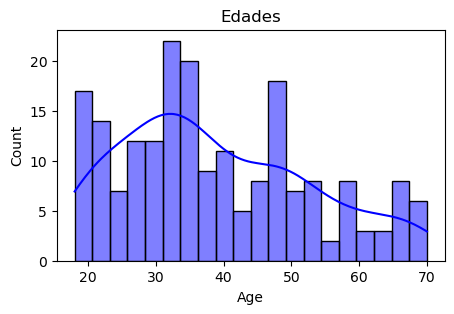

In [138]:
plt.figure(figsize=(5, 3))
sns.histplot(data=data, x="Age", bins=20, kde=True, color="blue")
plt.title("Edades")
plt.savefig("1.png") 
plt.show()


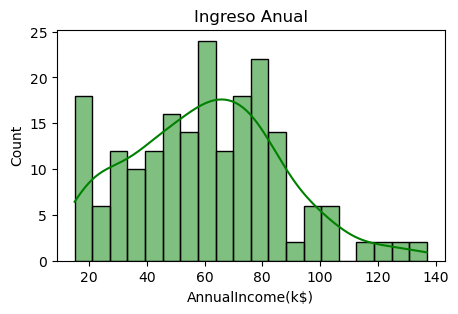

In [140]:
plt.figure(figsize=(5, 3))
sns.histplot(data=data, x="AnnualIncome(k$)", bins=20, kde=True, color="green")
plt.title("Ingreso Anual")
plt.savefig("2.png") 
plt.show()


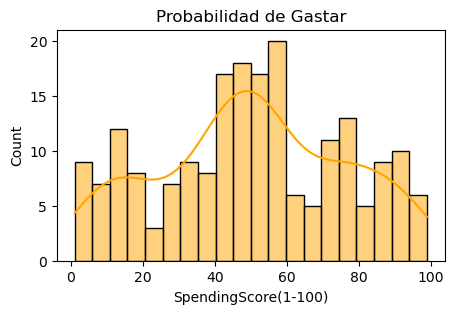

In [142]:
plt.figure(figsize=(5, 3))
sns.histplot(data=data, x="SpendingScore(1-100)", bins=20, kde=True, color="orange")
plt.title("Probabilidad de Gastar")
plt.savefig("3.png") 
plt.show()


5. Realizar gráfico de barras mostrando cantidad de hombres y mujeres

In [145]:
df = data.groupby(["Gender"]).count().reset_index()
df

,Gender,CustomerID,Age,AnnualIncome(k$),SpendingScore(1-100)
0,Female,112,112,112,112
1,Male,88,88,88,88


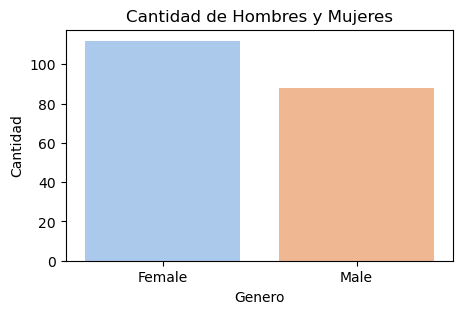

In [149]:
plt.figure(figsize=(5, 3))
sns.barplot(data=df, x="Gender", y="CustomerID", hue="Gender", palette="pastel", legend=False)
plt.title("Cantidad de Hombres y Mujeres")
plt.xlabel("Genero")
plt.ylabel("Cantidad")
plt.savefig("4.png")
plt.show()

In [151]:
sns.countplot

<function seaborn.categorical.countplot(data=None, *, x=None, y=None, hue=None, order=None, hue_order=None, orient=None, color=None, palette=None, saturation=0.75, fill=True, hue_norm=None, stat='count', width=0.8, dodge='auto', gap=0, log_scale=None, native_scale=False, formatter=None, legend='auto', ax=None, **kwargs)>

6. Analizar correlación entre las 3 columnas numéricas.\
   En la clusterización es algo malo que dos columnas estén muy correlacionadas, ¿crees que lo correcto sería usar todas?

In [154]:
numeric_cols = ["Age", "AnnualIncome(k$)", "SpendingScore(1-100)"]
data[numeric_cols].corr()

,Age,AnnualIncome(k$),SpendingScore(1-100)
Age,1.000000,-0.012398,-0.327227
AnnualIncome(k$),-0.012398,1.000000,0.009903
SpendingScore(1-100),-0.327227,0.009903,1.000000


In [156]:
# no hay una correlacion marcada entre columnas
# El negativo dice que la gente mayor gasta mas y nos menosres gastan menos

7. Normalizar los datos de la tabla. No usar estos datos en los siguientes puntos, K-Menas se encarga de normalizar los datos

In [159]:
scaler = MinMaxScaler()
data_normalized = data.copy()
data_normalized[numeric_cols] = scaler.fit_transform(data[numeric_cols])
data_normalized

,CustomerID,Gender,Age,AnnualIncome(k$),SpendingScore(1-100)
0,1,Male,0.019231,0.000000,0.387755
1,2,Male,0.057692,0.000000,0.816327
2,3,Female,0.038462,0.008197,0.051020
3,4,Female,0.096154,0.008197,0.775510
4,5,Female,0.250000,0.016393,0.397959
...,...,...,...,...,...
195,196,Female,0.326923,0.860656,0.795918
196,197,Female,0.519231,0.909836,0.275510
197,198,Male,0.269231,0.909836,0.744898
198,199,Male,0.269231,1.000000,0.173469


8. Realizar clusterización con las columnas Age y Annual Income (k$)
   * Analizar con el método del codo el número de cluster óptimo
   * Agregar columna con cluster a copia dataset
   * Graficar los clusters
   * Calcular silueta

In [162]:
data_2col = data[["Age", "AnnualIncome(k$)"]]
data_2col

,Age,AnnualIncome(k$)
0,19,15
1,21,15
2,20,16
3,23,16
4,31,17
...,...,...
195,35,120
196,45,126
197,32,126
198,32,137


In [164]:
acum = []
for i in range(1,11):
    modelo = KMeans(
        n_clusters = i, # numero de centoides (o semillas en cada iteración)
        n_init = 10, # cuantas veces distintas voy a tirar i puntos rojos
        max_iter = 300 # cuantas veces itero por cada tirada de 5 semillas
    )
    modelo.fit(data_2col)
    acum.append([i, modelo.inertia_])
acum

C:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows wi

[[1, 176108.77999999997],
 [2, 87159.30436535942],
 [3, 59492.737994932715],
 [4, 39529.8879673635],
 [5, 31659.353138717815],
 [6, 25399.022004416984],
 [7, 21818.32982934847],
 [8, 18842.04933385836],
 [9, 16135.854997639024],
 [10, 13701.349293950992]]

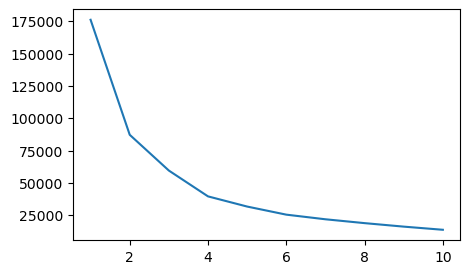

In [166]:
plt.figure(figsize=(5, 3))
sns.lineplot(x = np.array(acum)[:,0], y = np.array(acum)[:, 1])
plt.savefig("5.png") 

In [168]:
modelo = KMeans(
    n_clusters = 4, # numero de centoides (o semillas en cada iteración)
    n_init = 10, # cuantas veces distintas voy a tirar 5 puntos rojos
    max_iter = 300 # cuantas veces itero por cada tirada de 5 semillas
)
modelo.fit(data_2col)

C:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


KMeans(n_clusters=4, n_init=10)

In [170]:
data_2col.shape

(200, 2)

In [172]:
len(modelo.labels_)

200

In [174]:
np.unique(modelo.labels_)

array([0, 1, 2, 3])

In [176]:
data_2col["Cluster"] = modelo.fit_predict(data_2col)
data_2col.head()

C:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\user\AppData\Local\Temp\ipykernel_19160\2441995084.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2col["Cluster"] = modelo.fit_predict(data_2col)


,Age,AnnualIncome(k$),Cluster
0,19,15,2
1,21,15,2
2,20,16,2
3,23,16,2
4,31,17,2


In [178]:
labels = modelo.labels_  # Etiquetas de cada punto
centroids = modelo.cluster_centers_  # Centros de los clusters

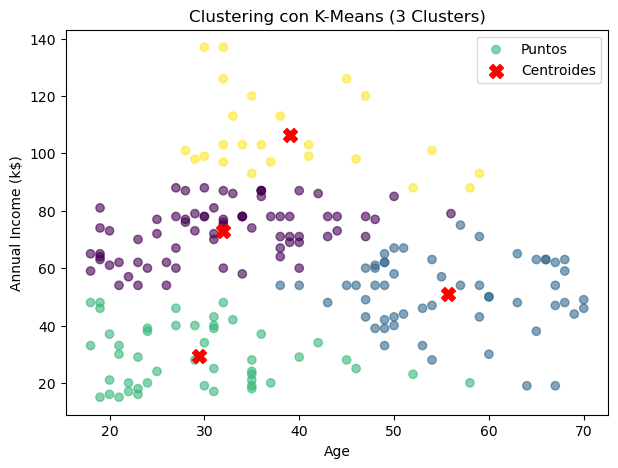

In [180]:
# Graficar los clusters
plt.figure(figsize=(7, 5))
plt.scatter(data_2col["Age"], data_2col["AnnualIncome(k$)"], c=data_2col["Cluster"], cmap='viridis', alpha=0.6, label="Puntos")
plt.scatter(centroids[:, 0], centroids[:, 1],  c='red', marker='X', s=100, label="Centroides")
plt.xlabel("Age")
plt.ylabel("Annual Income (k$)")
plt.title("Clustering con K-Means (3 Clusters)")
plt.legend()
plt.savefig("6.png") 
plt.show()


In [182]:
silhouette_score(data_2col, modelo.labels_)

0.4351115711319058

9. Realizar clusterización con las columnas Annual Income (k$) y Spending Score (1-100)
   * Analizar con el método del codo el número de cluster óptimo
   * Agregar columna con cluster a copia dataset
   * Graficar los clusters
   * Calcular silueta

In [185]:
data_2colb = data[["AnnualIncome(k$)", "SpendingScore(1-100)"]]

In [187]:
acum = []
for i in range(1,11):
    modelo = KMeans(
        n_clusters = i, # numero de centoides (o semillas en cada iteración)
        n_init = 10, # cuantas veces distintas voy a tirar i puntos rojos
        max_iter = 300 # cuantas veces itero por cada tirada de 5 semillas
    )
    modelo.fit(data_2colb)
    acum.append([i, modelo.inertia_])

C:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows wi

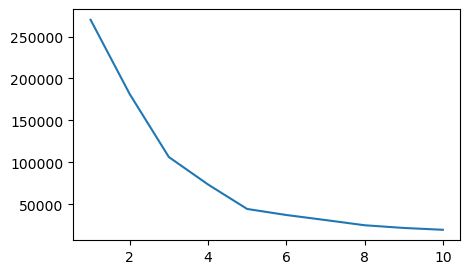

In [189]:
plt.figure(figsize=(5, 3))
sns.lineplot(x = np.array(acum)[:,0], y = np.array(acum)[:, 1])
plt.savefig("7.png") 

In [191]:
modelo = KMeans(
    n_clusters = 5, # numero de centoides (o semillas en cada iteración)
    n_init = 10, # cuantas veces distintas voy a tirar 5 puntos rojos
    max_iter = 300 # cuantas veces itero por cada tirada de 5 semillas
)
modelo.fit(data_2colb)

C:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


KMeans(n_clusters=5, n_init=10)

In [193]:
data_2colb["Cluster"] = modelo.fit_predict(data_2colb)

C:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\user\AppData\Local\Temp\ipykernel_19160\1177807211.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2colb["Cluster"] = modelo.fit_predict(data_2colb)


In [195]:
labels = modelo.labels_  # Etiquetas de cada punto
centroids = modelo.cluster_centers_  # Centros de los clusters

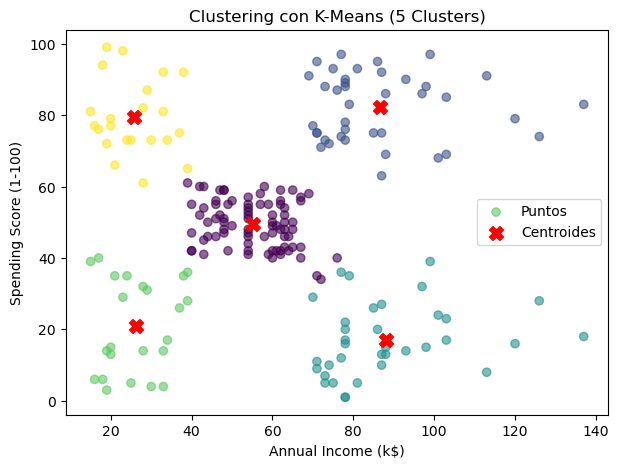

In [197]:
# Graficar los clusters
plt.figure(figsize=(7, 5))
plt.scatter(data_2colb["AnnualIncome(k$)"], data_2colb["SpendingScore(1-100)"], c=data_2colb["Cluster"], cmap='viridis', alpha=0.6, label="Puntos")
plt.scatter(centroids[:, 0], centroids[:, 1],  c='red', marker='X', s=100, label="Centroides")
plt.xlabel("Annual Income (k$)")
plt.ylabel("Spending Score (1-100)")
plt.title("Clustering con K-Means (5 Clusters)")
plt.legend()
plt.savefig("8.png") 
plt.show()


In [199]:
# Calcular silueta
silhouette_score(data_2colb, modelo.labels_)

0.5553511832664837

10. Realizar clusterización con las columnas Age, Annual Income (k$) y Spending Score (1-100)
   * Analizar con el método del codo el número de cluster óptimo
   * Agregar columna con cluster a copia dataset
   * Calcular silueta

In [202]:
data_3col = data[["Age", "AnnualIncome(k$)", "SpendingScore(1-100)"]]

In [204]:
# Analizar con el método del codo el número de cluster óptimo
acum = []
for i in range(1,11):
    modelo = KMeans(
        n_clusters = i, # numero de centoides (o semillas en cada iteración)
        n_init = 10, # cuantas veces distintas voy a tirar i puntos rojos
        max_iter = 300 # cuantas veces itero por cada tirada de 5 semillas
    )
    modelo.fit(data_3col)
    acum.append([i, modelo.inertia_])

C:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows wi

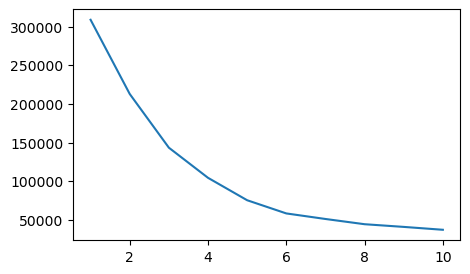

In [206]:
plt.figure(figsize=(5, 3))
sns.lineplot(x = np.array(acum)[:,0], y = np.array(acum)[:, 1])
plt.savefig("9.png") 

In [214]:
modelo = KMeans(
    n_clusters = 6, # numero de centoides (o semillas en cada iteración)
    n_init = 10, # cuantas veces distintas voy a tirar 5 puntos rojos
    max_iter = 300 # cuantas veces itero por cada tirada de 5 semillas
)
modelo.fit(data_3col)


C:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


KMeans(n_clusters=6, n_init=10)

In [216]:
# Agregar columna con cluster a copia dataset
data_3col["Cluster"] = modelo.fit_predict(data_2col)
data_3col

C:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\user\AppData\Local\Temp\ipykernel_19160\2189575186.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_3col["Cluster"] = modelo.fit_predict(data_2col)


,Age,AnnualIncome(k$),SpendingScore(1-100),Cluster
0,19,15,39,0
1,21,15,81,0
2,20,16,6,0
3,23,16,77,0
4,31,17,40,0
...,...,...,...,...
195,35,120,79,3
196,45,126,28,3
197,32,126,74,3
198,32,137,18,3


In [218]:
# Obtener centroides
centroids = modelo.cluster_centers_

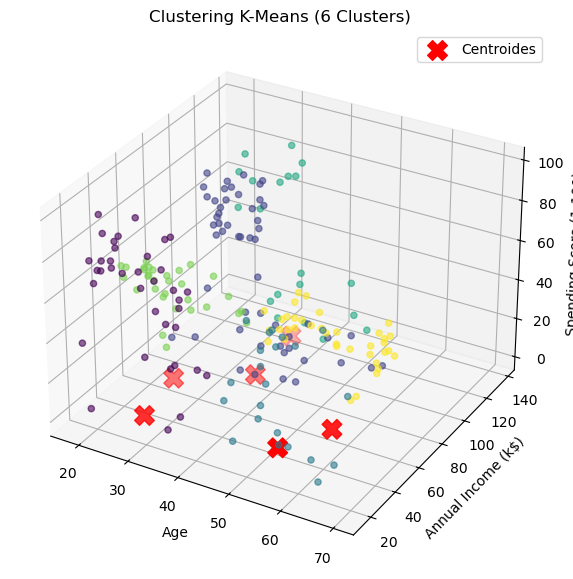

In [220]:
# Graficamos en 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Graficar los puntos de cada cluster
ax.scatter(data_3col["Age"], data_3col["AnnualIncome(k$)"], data_3col["SpendingScore(1-100)"], c=data_3col["Cluster"], cmap='viridis', alpha=0.6)

# Graficar los centroides
ax.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2], c='red', marker='X', s=200, label="Centroides")

# Etiquetas y título
ax.set_xlabel('Age')
ax.set_ylabel('Annual Income (k$)')
ax.set_zlabel('Spending Score (1-100)')
ax.set_title("Clustering K-Means (6 Clusters)")
plt.legend()
plt.savefig("10.png") 
plt.show()


In [222]:
# Calcular silueta
silhouette_score(data_3col, modelo.labels_)

0.20228975668975188

11. Interpretar los clusters del mejor resultado y asignarle un nombre a cada uno de los clusters

In [225]:
# data[["Age", "AnnualIncome(k$)"]] 4 Clusters --> Silhouette Score 0.4349591404704756
# data[["AnnualIncome(k$)", "SpendingScore(1-100)"]] 5 Clusters --> Silhouette Score 0.5546256572191618
# data[["Age", "AnnualIncome(k$)", "SpendingScore(1-100)"]] 6 Clusters --> Silhouette Score 0.3846996040423836

Mejor 5 Clusters tomando "AnnualIncome(k$)", "SpendingScore(1-100)" ya que se acerca mas a 1

In [228]:
data[["AnnualIncome(k$)", "SpendingScore(1-100)"]].corr()

,AnnualIncome(k$),SpendingScore(1-100)
AnnualIncome(k$),1.000000,0.009903
SpendingScore(1-100),0.009903,1.000000


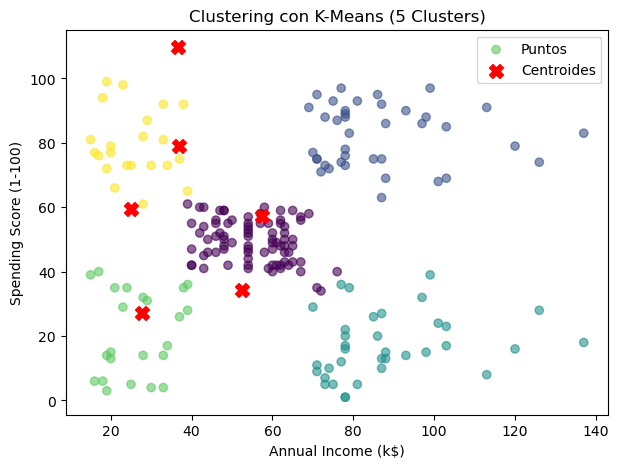

In [230]:
# Graficar los clusters
plt.figure(figsize=(7, 5))
plt.scatter(data_2colb["AnnualIncome(k$)"], data_2colb["SpendingScore(1-100)"], c=data_2colb["Cluster"], cmap='viridis', alpha=0.6, label="Puntos")
plt.scatter(centroids[:, 0], centroids[:, 1],  c='red', marker='X', s=100, label="Centroides")
plt.xlabel("Annual Income (k$)")
plt.ylabel("Spending Score (1-100)")
plt.title("Clustering con K-Means (5 Clusters)")
plt.legend()
plt.savefig("11.png") 
plt.show()


In [232]:
#Spending Score (1-100) representa un índice de gasto que indica qué tan probable es que un cliente gaste dinero en un producto o servicio.

# Valor bajo (1-40): Cliente con bajo nivel de gasto.
# Valor medio (41-70): Cliente con un nivel de gasto moderado.
# Valor alto (71-100): Cliente que gasta mucho.

In [234]:
data_2colb.groupby('Cluster').mean().reset_index()

,Cluster,AnnualIncome(k$),SpendingScore(1-100)
0,0,55.296296,49.518519
1,1,86.538462,82.128205
2,2,88.200000,17.114286
3,3,26.304348,20.913043
4,4,25.727273,79.363636


Grupos:

0. Mas Gana baja probabilidad de gastar
1. Mas Gana alta probabilidad de gastar
2. Menos Gana baja probabilidad de gastar
3. Ingreso medio probabildiad media de gastar
5. Menos Gana alta probabilidad de gastar

In [237]:
data_2colb['Cluster'].replace({
    0:'Disfrutones' ,
    1:'Ratas' ,
    2:'Racional' ,
    3:'Vividores/Endeudados' ,
    4:'Supervivientes'
})

0      Vividores/Endeudados
1            Supervivientes
2      Vividores/Endeudados
3            Supervivientes
4      Vividores/Endeudados
               ...         
195                   Ratas
196                Racional
197                   Ratas
198                Racional
199                   Ratas
Name: Cluster, Length: 200, dtype: object

In [239]:
data.replace({"Male": "Hombre", "Female": "Mujer", 0: "Sin Datos"}, inplace=True)

In [241]:
data_2colb.groupby('Cluster').mean().reset_index()

,Cluster,AnnualIncome(k$),SpendingScore(1-100)
0,0,55.296296,49.518519
1,1,86.538462,82.128205
2,2,88.200000,17.114286
3,3,26.304348,20.913043
4,4,25.727273,79.363636
